In [1]:
import io
import pandas as pd
import numpy as np
from transitions.extensions import GraphMachine
from IPython.display import Image, display

# Теория автоматов

Исследование процесса перевода абстрактного (*АА*) автомата в автомат структурный (*СА*).\
Документ основан на [учебном пособии][1] Ожиганова А. А. "Теория автоматов".

План документа:

1. Общая теория
2. Описание *АА* Мили с помощью таблиц переходов
3. Реализация модели автомата с помощью библиотеки [transitions][2]
4. Запуск автомата на входном слове `213121331`
5. ...
6. Преобразование *АА* в *СА*  с помощью библиотеки [pyeda][3]

[1]: https://books.ifmo.ru/book/826/teoriya_avtomatov._uchebnoe_posobie.htm
[2]: https://github.com/pytransitions/transitions
[3]: https://pyeda.readthedocs.io/en/latest/index.html

## Общая теория

Напомним, что любой автомат описывается шестикомпонентным набором:

$S = (A, Z, W, \delta, \lambda, a1)$, где

1. $A = {a_1,...,a_m,...,a_M}$ - множество состояний или алфавит состояний *АА*
2. $Z = {z_1,...,z_f,...,z_F}$ - множество входных сигналов или входной алфавит *АА*
3. $W = {w_1,...,w_g,...,w_G}$ - множество выходных сигналов или выходной алфавит *АА*
4. $\delta$ - функция переходов *АА*: $\delta(a_m, z_f) \mapsto a_s\ |\ a_m, a_s \in A$
5. $\lambda$ - функция выходов *АА*: $\lambda(a_m, z_f) \mapsto w_g\ |\ a_m \in A, w_g \in G$
7. $а_1$ - начальное состояние *АА*

## Описание АА

Задаём функции $\delta$ и $\lambda$

In [2]:
deltaA = np.array(
    [['a2', '', 'a1'],
     ['a3', 'a1', ''],
     ['a2', 'a3', 'a3']])
lmbdaA = np.array(
    [['w1', '', 'w2'],
     ['w4', 'w5', ''],
     ['w2', 'w1', 'w3']])

In [3]:
delta = pd.DataFrame(
    deltaA,
    columns=['a1', 'a2', 'a3'],
    index=['z1', 'z2', 'z3'])
delta

,a1,a2,a3
z1,a2,,a1
z2,a3,a1,
z3,a2,a3,a3


In [4]:
lmbda = pd.DataFrame(
    lmbdaA,
    columns=['a1', 'a2', 'a3'],
    index=['z1', 'z2', 'z3'])
lmbda

,a1,a2,a3
z1,w1,,w2
z2,w4,w5,
z3,w2,w1,w3


In [5]:
desc = np.dstack((delta,lmbda))
print(desc.shape)
desc

(3, 3, 2)


array([[['a2', 'w1'],
        ['', ''],
        ['a1', 'w2']],

       [['a3', 'w4'],
        ['a1', 'w5'],
        ['', '']],

       [['a2', 'w2'],
        ['a3', 'w1'],
        ['a3', 'w3']]], dtype=object)

In [6]:
class Matter():
    states=['a1', 'a2', 'a3']
    
    def __init__(self, model):
        self.states = []
        self.dictionary = {}

        for a in range(model.shape[1]):
            state = 'a' + str(a + 1)
            self.states.append(state)        
        
        self.machine = GraphMachine(
            model=self,
            states=self.states, 
            initial='a1')
        
        for z in range(model.shape[0]):
            currSig = 'z' + str(z + 1)
            #print(currSig)
            for a in range(model.shape[1]):
                currState = 'a' + str(a + 1)
                #print(currState)
                state = model[z, a, 0]
                sig = model[z, a, 1]

                if not state:
                    continue
                self.machine.add_transition(currSig, currState, state, after=sig)
                print(currSig, currState, state, sig)

        for z in range(model.shape[0]):
            num = str(z + 1)
            sig = 'z' + num
            self.dictionary[num] = sig

        self.output = []

    def w1(self):
        self.output.append('a')
    def w2(self):
        self.output.append('b')
    def w3(self):
        self.output.append('c')
    def w4(self):
        self.output.append('d')
    def w5(self):
        self.output.append('e')

    def input(self, inp):
        self.output = []
        for c in inp:
            eventName = self.dictionary[c]
            event = getattr(self, eventName)
            event()
    
    def print(self):
        print(self.output)
    
    def show_graph(self, **kwargs):        
        stream = io.BytesIO()
        self.get_graph(**kwargs).draw(stream, prog='dot', format='png')
        display(Image(stream.getvalue()))

In [7]:
model = Matter(desc)

z1 a1 a2 w1
z1 a3 a1 w2
z2 a1 a3 w4
z2 a2 a1 w5
z3 a1 a2 w2
z3 a2 a3 w1
z3 a3 a3 w3


In [8]:
model.z2()
model.state

'a3'

In [9]:
model.z1()
model.state

'a1'

In [10]:
model.z3()
model.state

'a2'

In [11]:
model.input('213')

In [12]:
model.print()

['e', 'a', 'a']


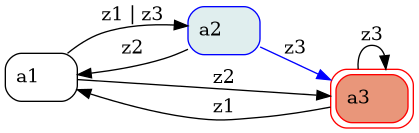

In [13]:
model.show_graph()